In [13]:
import s3fs
import boto3
!pip install ultralytics
from PIL import Image
import numpy as np
import hashlib
import io
import json

import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision import transforms, models
from torchvision.models import vgg16, VGG16_Weights

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay,classification_report

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.7/40.7 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 757.2/757.2 kB 44.9 MB/s eta 0:00:00


In [2]:
def init_clients():
    return boto3.client("s3"), s3fs.S3FileSystem()

boto3_s3, s3fs_ = init_clients()

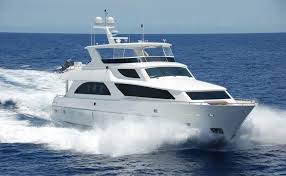

In [9]:
def get_test_data(bucket: str, boto_s3: boto3.client("s3"), s3fs_: s3fs.S3FileSystem()):
    image_path = test_x
    # Remove the first part of the path
    image_path = "/".join(image_path.split("/")[1:])
    # Open the image
    print(image_path)
    image_data = boto_s3.get_object(Bucket=bucket, Key=image_path)['Body'].read()
    image = Image.open(io.BytesIO(image_data))
    # Display the image
    image.show()

def get_test_data_boat():
    image_path = 'boat_ext.jpg'  # Specify the local path to your image
    # Open the image
    image = Image.open(image_path)
    # Display the image
    image.show()

get_test_data_boat()

In [ ]:
def preprocess_image(image_bytes):
    # Open the image as bytes
    image = Image.open(io.BytesIO(image_bytes))

    # Convert to grayscale
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Convert image to numpy array
    image_np = np.array(image)

    # Convert the numpy array to PyTorch tensor
    image_tensor = torch.tensor(image_np)

    # Convert the tensor to 3D RGB (if it's not already)
    if len(image_tensor.shape) == 2:
        image_tensor = image_tensor.unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.permute(2, 0, 1)  # Convert HWC to CHW

    # Normalize to [0, 1]
    image_tensor = image_tensor.float() / 255.0

    return image_tensor


def process_duplicates_image_ids(model,image_paths: list,
                                 bucket: str,
                              boto_s3: boto3.client("s3"), 
                              s3fs_: s3fs.S3FileSystem()):
    if model == 'ResNet':
        preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(256),transforms.ToTensor(),])
    if model == 'VGG16':
        preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(256),transforms.ToTensor(),])
    if model == 'SVM':
        preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(256),transforms.ToTensor(),])
    if model == 'YOLO':
        preprocess = transforms.Compose([transforms.Resize(256),transforms.CenterCrop(256),transforms.ToTensor(),])
    image_tensors = []
    ad_image = test_x
    if ad_image.lower().endswith(('.jpg', '.jpeg', '.png')):

        image_path = "/".join(ad_image.split("/")[1:])
        s3_object = boto_s3.get_object(Bucket=bucket, Key=image_path)
        image_bytes = s3_object['Body'].read()
        image_tensor = preprocess_image(image_bytes)
        image_tensors.append(image_tensor)
#     image_tensors = torch.stack(image_tensors)
    image_tensors_preprocessed = torch.stack([preprocess(transforms.functional.to_pil_image(image)) for image in image_tensors])
    # Display the shape and dtype of the tensor
    print("Tensor Shape:", image_tensors_preprocessed.shape)
    print("Tensor Dtype:", image_tensors_preprocessed.dtype)
    return image_tensors_preprocessed

In [14]:
# import YOLO model
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n-cls.pt') # load a pretrained model (recommended for training)

# # Train the model
# model.train(data='/kaggle/working/data', epochs=5)

In [30]:
def preprocess_image_boat(image_path):
    # Open the image file
    image = Image.open(image_path)

    # Convert to RGB if not already
    if image.mode != 'RGB':
        image = image.convert('RGB')

    # Resize the image to match the expected input shape
    transform = transforms.Compose([
        transforms.Resize((640, 640)),  # Resize to match the model's input shape
        transforms.ToTensor(),  # Convert PIL image to PyTorch tensor
    ])
    image_tensor = transform(image)

    return image_tensor

# Example usage

In [36]:
results = model(preprocess_image_boat('boat_ext.jpg'))


WARNING ⚠️ torch.Tensor inputs should be BCHW i.e. shape(1, 3, 640, 640) divisible by stride 32. Input shape(3, 640, 640) is incompatible.
0: 640x640 yawl 0.09, killer_whale 0.08, grey_whale 0.08, speedboat 0.06, catamaran 0.06, 4.8ms
Speed: 1.3ms preprocess, 4.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


In [ ]:
names_dict = results[0].names
labels_all = []
for result in results:
    labels = []
    probs = result.probs
    topk_values, id_10 = torch.topk(result.probs.data, k=7)
    id_10 = np.array([tensor.item() for tensor in id_10])
    for i in range(len(id_10)):
        label = names_dict[id_10[i]]
        if topk_values[i] > 0.01:
            labels.append(label)
        else:
            labels.append('')
    labels_all.append(labels)

In [ ]:
labels_all

In [ ]:
test_y[204]